<img src="assets/assistant_logo.png"/>

# Acumos Property Assistant

What's my Home Worth?

Many real estate agents follow a notion of comps (or comparables) when pricing a home. Problem here is that this is often subject to an individual realtors' biases and often only looks at 2-3 properties in the area as a comparison.

What's my home worth is a machine learning model deployed on the Acumos store for pricing your home based on fundamental property characteristics.

More specifically, we survey the intrinsic properties of a home, such as number of bathrooms, number of bedrooms, square footage, and location, as sampled from the Redfin website (www.redfin.com), and allow users to price their home using a large dataset of collected properties.

By no means is this an exhaustive model, but should give users as idea of what their home (or someone else's home) is at least worth in the current market.




In [144]:
%matplotlib inline
import os
import shutil

import numpy as np
import scipy as sp
import matplotlib as mp
import matplotlib.pyplot as plt
import scipy.linalg.interpolative as sli
import seaborn as sns
import pandas as pd
import math
# import xgboost as xgb
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from scipy import stats
# from skimage import color

from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

pw = os.environ['ACUMOS_PASSWORD']
user = os.environ['ACUMOS_USERNAME']

MODEL_PATH = "Acumos Property Assistant"

pd.set_option('display.float_format', lambda x: '%.2f' % x)

from acumos.modeling import Model, List, Dict, create_namedtuple, create_dataframe
from acumos.session import AcumosSession
# Session Endpoints for Acumos Challenge model upload and auth.
# session = AcumosSession(push_api="https://acumos-challenge.org/onboarding-app/v2/models",
#                         auth_api="https://acumos-challenge.org/onboarding-app/v2/auth")
session = AcumosSession()

print('done')

done


In [145]:
REDFIN_TRAIN_CSV = os.path.join("assets","redfin_2018_8_boston.csv")
REDFIN_TEST_CSV = os.path.join("assets", "redfin_2018_active_boston.csv")

In [146]:
def rename_col(x):
    return x.lower().replace(' ', '_').replace('$', 'cost').replace('/', '_per_')


### Main Redfin Acumos Model

Using recently sold properties to predict current property values, includes qualitative (encoded) and quantitative metrics.

In [147]:
class RedfinAcumosModel:
    URL_COL = 'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)'
    DROP_COLS = list(map(rename_col, [URL_COL, 'NEXT OPEN HOUSE START TIME', 'FAVORITE', 'INTERESTED', 'ZIP', 'SALE TYPE',
                 'NEXT OPEN HOUSE END TIME','STATUS', 'SOLD DATE', 'MLS#',
                 'SOURCE', 'ADDRESS','LATITUDE','LONGITUDE'])) # 'LISTING ID'
    ENCODED_COLS = list(map(rename_col, ['CITY', 'STATE', 'PROPERTY TYPE', 'LOCATION']))

    def __init__(self):
        # self.train = self.process_train_data(self.data)
        self.X = None
        self.y = None
        self.df = None
        return
        

    def get_formatted_test_cols(self, data):
        data_cols = set(data.columns.values)
        model_cols = list(data_cols - set(self.DROP_COLS))
        
        df_num = data.select_dtypes(exclude=[np.number])
        raw_cols = list(df_num.columns.values)
        
        model_cols = list(map(rename_col, model_cols))
        model_cols.remove('price')
        
        dtypes = list(map(lambda x: "List[str]" if x in raw_cols else "List[%s]" % str(data[x].dtype)[:-2], data))
        zipped_cols = list(zip(model_cols, dtypes))
        res = str(zipped_cols).replace("'List", "List").replace("]'", "]")
        return res

    
    def encode_onehot(self, df, cols):
        """
        One-hot encoding is applied to columns specified in a pandas DataFrame.

        Modified from: https://gist.github.com/kljensen/5452382

        Details:

        http://en.wikipedia.org/wiki/One-hot
        http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

        @param df pandas DataFrame
        @param cols a list of columns to encode
        @return a DataFrame with one-hot encoding
        """
        vec = DictVectorizer()

        vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict(orient='records')).toarray())
        vec_data.columns = vec.get_feature_names()
        vec_data.index = df.index

        df = df.drop(cols, axis=1)
        df = df.join(vec_data)
        self.vec_data_cols = vec_data.columns.values
                     
        return df
    
    
    def process_data(self, data, training=False):
        # First interpolate on missing values.
        data = data.interpolate()
            
        # Remove any remaining NaN and standardize string fields.
        data['lot_size'] = data['lot_size'].replace(np.NaN, 0)
        data['city'] = data['city'].astype(str).apply(lambda x: x.lower())
        data['property_type'] = data['property_type'].astype(str).apply(lambda x: x.lower())

        # Convert string columns to one hot encoding.
        data = self.encode_onehot(data, RedfinAcumosModel.ENCODED_COLS)

        # Drop the original location value (after being encoded).
        if 'location' in data.columns.values:
            data = data.drop('location', axis=1)
            
        # Drop unique/unknown location cols.
        location_cols = [x for x in data.columns.values if 'location' in x]
        for c in location_cols:
            if sum(data[c]) < 2:
                data = data.drop(c, axis=1)

        # print('processed data columns: %s' % data.columns.values)
        if training:
            self.df = data
            self.X = self.df.drop('price', axis=1)
            self.y = self.df['price']
        return data

    def get_encodings(self, data):
        self.encoders = {}
        for c in RedfinAcumosModel.ENCODED_COLS:
            le = LabelEncoder()
            data[c] = data[c].apply(lambda x: x if not pd.isnull(x) else 'Null')
            le.fit(data[c])
            data[c] = le.transform(data[c])
            self.encoders[c] = le
    
    def transform(self, data):
        for c in RedfinAcumosModel.ENCODED_COLS:
            data[c] = data[c].apply(lambda x: x if not pd.isnull(x) else 'Null')
            data[c] = self.encoders[c].transform(data[c])
        return data
    
    def inverse_transform(self, data):
        for c in RedfinAcumosModel.ENCODED_COLS:
            data[c] = self.encoders[c].inverse_transform(data[c])
        return data
    
    def cat_correlation(self, category, transform_func=None):
        cat = self.df[category]
        if transform_func:
            cat = cat.apply(lambda x: transform_func(x))
        cat_df = pd.get_dummies(cat).join(self.df['price']).astype(int)
        if 'nan' in cat_df.columns.values:
            del cat_df['nan']
        levels =  len(cat_df.columns.values)
        if levels > 60:
            print('%s: too many unique categories %d' % (category, levels))
            return cat_df
        corr = cat_df.corr()
        plt.figure(figsize=(16, 16))
        sns.heatmap(corr, vmax=1, square=True)
        return cat_df
    
    def match_train(self, test_df):
        # Merge test cols with train_cols
        test_cols = set(test_df.columns.values)
        train_cols = set(self.X.columns.values)
        print("\n=== Merging Encoded Columns for Training ===\n")
        needed_cols = train_cols - test_cols
        extra_cols = test_cols - train_cols
#         print('Train data needs columns: %s' % needed_cols)
#         print('\nTrain data should remove columns: %s' % extra_cols)
        if extra_cols:
            test_df = test_df.drop(extra_cols, axis=1)
        if needed_cols: # add the necessary columns to match test set and fill with zeroes
            test_df = test_df.reindex(columns=self.X.columns.values, fill_value=0)
        
        return test_df
    
    def train_model(self):
        # self.model = Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', LinearRegression())])
        self.model = LinearRegression()
        # model = LinearRegression()
        # print('Final cols: %s' % ', '.join(self.X.columns.values))
        self.model.fit(self.X, self.y)

    def predict_xgb(self, data, d=4, est=200):
        self.clf = xgb.XGBRegressor(max_depth=d, n_estimators=est)
        self.clf.fit(self.X, self.y)
        pred = self.clf.predict(data)
        return pred
    
# Utility functions
def print_loc_cols(df):
    cols = [x for x in df.columns.values if 'location' in x]
    for c in cols:
        print("%40s: %d" % (c, sum(df[c])))

def convert_int(x):
    try:
        return int(x)
    except:
        return float('nan')

def reformat_train_data(data):
    data = data.rename(rename_col, axis='columns')
    data = data.drop(RedfinAcumosModel.DROP_COLS, axis=1)
    data = data[(data['price'] < 1.5*10**6) & (data['price'] > 10**5) & (data['property_type'] != 'Vacant Land')]
    return data

def reformat_test_data(data):
    data = data.rename(rename_col, axis='columns')
    data = data.drop(RedfinAcumosModel.DROP_COLS, axis=1)
    return data


In [148]:

train = reformat_train_data(pd.read_csv(REDFIN_TRAIN_CSV))
train_cols = train.columns.values
print(train_cols)
np.set_printoptions(precision=2) #2 decimal places
np.set_printoptions(suppress=True) #remove scientific notation



['property_type' 'city' 'state' 'price' 'beds' 'baths' 'location'
 'square_feet' 'lot_size' 'year_built' 'days_on_market'
 'cost_per_square_feet' 'hoa_per_month']


This is the list of core property types as used by Redfin

In [149]:
set(train['property_type'])

{'Condo/Co-op',
 'Multi-Family (2-4 Unit)',
 'Multi-Family (5+ Unit)',
 'Other',
 'Parking',
 'Single Family Residential',
 'Townhouse',
 'Unknown'}

In [150]:
redfin = RedfinAcumosModel()

model_cols = redfin.get_formatted_test_cols(train)
print(model_cols)
# print(len(model_cols))



[('cost_per_square_feet', List[str]), ('baths', List[str]), ('beds', List[str]), ('square_feet', List[float]), ('property_type', List[float]), ('year_built', List[float]), ('lot_size', List[str]), ('hoa_per_month', List[float]), ('days_on_market', List[float]), ('location', List[float]), ('state', List[float]), ('city', List[float])]


### These are the required dataframe input arguments for the model.

In [151]:
# items is the model_cols list from the previous slide
items = [('cost_per_square_feet', List[str]), ('baths', List[str]), ('beds', List[str]), ('square_feet', List[float]), ('property_type', List[float]), ('year_built', List[float]), ('lot_size', List[str]), ('hoa_per_month', List[float]), ('days_on_market', List[float]), ('location', List[float]), ('state', List[float]), ('city', List[float])]

HouseDataFrame = create_namedtuple('HouseDataFrame', items)


# here, an appropriate NamedTuple type is inferred from a pandas DataFrame
# HouseDataFrame = create_dataframe('HouseDataFrame', X_df)
print(HouseDataFrame.__doc__)

HouseDataFrame(cost_per_square_feet, baths, beds, square_feet, property_type, year_built, lot_size, hoa_per_month, days_on_market, location, state, city)


In [152]:
df = redfin.process_data(train, True)
redfin.df = df
redfin.df.info()

# These are the list of actual encoded columns to be used in the model

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2372 entries, 0 to 2658
Columns: 106 entries, price to state=MA
dtypes: float64(106)
memory usage: 2.0 MB


In [153]:
# redfin.y.describe()

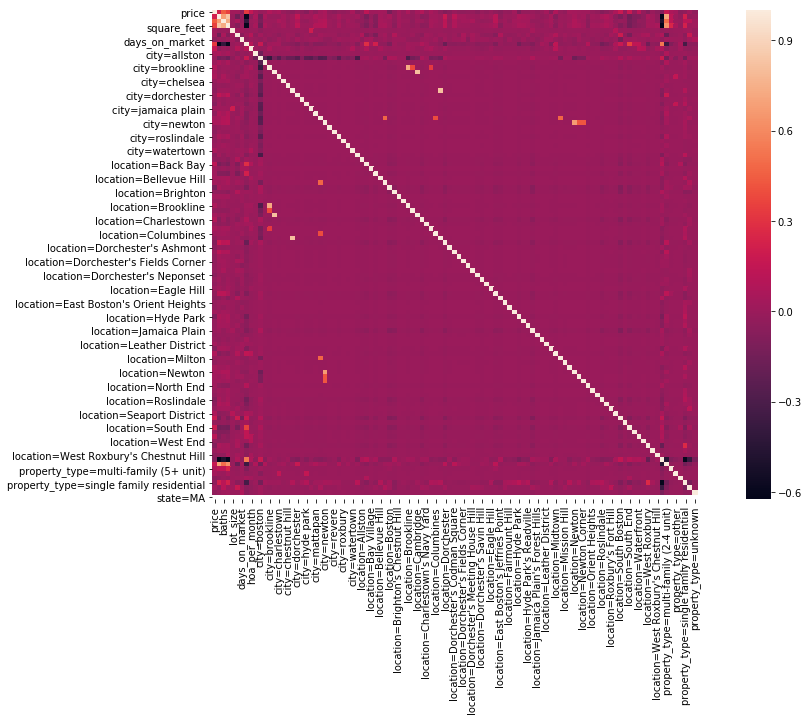

In [154]:
corr = df.corr()
plt.figure(figsize=(16, 9))
sns.heatmap(corr, vmax=1, square=True)

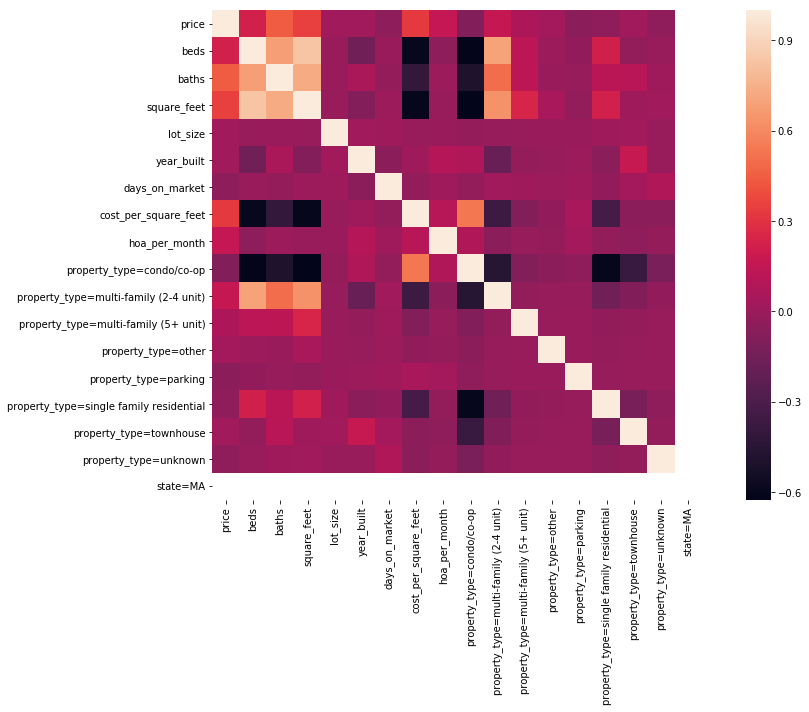

In [155]:
# Reduced correlation
location_cols = filter(lambda x: "location" in x or 'city' in x, df.columns.values)
reduced_df = df.drop(location_cols, axis=1)
corr = reduced_df.corr()
plt.figure(figsize=(16, 9))
sns.heatmap(corr, vmax=1, square=True)

# State variable would become relevant if we ran this home valuation on a state border. In this model, we keep the region local.

In [156]:
# IrisDataFrame = create_namedtuple('IrisDataFrame', [('sepal_length', List[str])])

# predict(redfin.X)

In [157]:
raw_test_df = pd.read_csv(REDFIN_TEST_CSV)
test_data = reformat_test_data(raw_test_df)
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1047 entries, 0 to 1046
Data columns (total 13 columns):
property_type           1046 non-null object
city                    1046 non-null object
state                   1046 non-null object
price                   1046 non-null float64
beds                    1019 non-null float64
baths                   1015 non-null float64
location                1046 non-null object
square_feet             1017 non-null float64
lot_size                551 non-null float64
year_built              1012 non-null float64
days_on_market          1042 non-null float64
cost_per_square_feet    1017 non-null float64
hoa_per_month           701 non-null float64
dtypes: float64(9), object(4)
memory usage: 106.4+ KB
None


In [158]:
# raw_test_df[raw_cols] = raw_test_df[raw_cols].astype(str)

In [159]:
def predict(data: HouseDataFrame) -> List[float]:
    test_df = redfin.process_data(data)
    # Train by merging locations/columns found in the train dataframe.
    test_df = redfin.match_train(test_df)
    redfin.train_model()
    print('Using %d Calculated Features for Valuation' % len(test_df.columns.values))
    return redfin.model.predict(test_df)

In [160]:
# results = predict(test_data)
acumos_test_data = pd.read_csv('assets/test_data.csv')
print(acumos_test_data.columns.values)
results = predict(acumos_test_data)



['city' 'property_type' 'square_feet' 'baths' 'hoa_per_month' 'lot_size'
 'location' 'state' 'beds' 'cost_per_square_feet' 'year_built'
 'days_on_market']

=== Merging Encoded Columns for Training ===

Using 105 Calculated Features for Valuation


In [161]:
result_df = pd.DataFrame()
result_df['address'] = raw_test_df['ADDRESS']
result_df['city'] = raw_test_df['CITY']
result_df['state'] = raw_test_df['STATE']
result_df['listing_price'] = raw_test_df['PRICE']
result_df['prediction'] = results

print("First 20 Predictions of Active Listings\n===")
print(result_df[:20])

print("\nMean Estimated Price of ALL current listings: $%.2f" % np.mean(results))

result_df.to_csv('assets/active_predictions.csv')
print('write predictions to csv')

First 20 Predictions of Active Listings
===
                        address    city state  listing_price  prediction
0             75 Highland St #3  Boston    MA      474900.00   310413.90
1              5 Eldridge Rd #2  Boston    MA      349000.00   295501.70
2                17 Paradise Ln  Dedham    MA      699000.00   719554.00
3                110 Park St #1  Boston    MA      649000.00   617456.72
4           111 Perkins St #101  Boston    MA      399000.00   482790.00
5           1 Hadley St Unit 1C  Boston    MA      774900.00   777435.42
6                35 Gates St #1  Boston    MA      779900.00   776322.25
7               61 Revere St #1  Boston    MA      724900.00   615308.81
8                40 Fay St #407  Boston    MA      647000.00   663470.32
9    23 Margaret Street, Unit 1  Boston    MA      689999.00   613206.63
10  52 Msgr Patrick J Lydon Way  Boston    MA      989900.00   880344.62
11                36 Deering Rd  Boston    MA      799900.00   782302.56
12     

In [162]:
raw_test_df['predicted'] = results

In [163]:
print(model_cols)

[('cost_per_square_feet', List[str]), ('baths', List[str]), ('beds', List[str]), ('square_feet', List[float]), ('property_type', List[float]), ('year_built', List[float]), ('lot_size', List[str]), ('hoa_per_month', List[float]), ('days_on_market', List[float]), ('location', List[float]), ('state', List[float]), ('city', List[float])]


In [164]:
# print(redfin.X.columns.values)
print(results)

[310413.9  295501.7  719554.   ... 910479.69 896887.84 762343.07]


In [165]:
cols = list(filter(lambda x: 'property' not in x and 'location' not in x and 'city' not in x, redfin.X.columns.values))

# print(test_df[:10])
print(cols)

['beds', 'baths', 'square_feet', 'lot_size', 'year_built', 'days_on_market', 'cost_per_square_feet', 'hoa_per_month', 'state=MA']


In [166]:
acumos_model = Model(appraise=predict)
if os.path.isdir(MODEL_PATH):
    shutil.rmtree(MODEL_PATH)
session.dump(acumos_model, MODEL_PATH, '.')
# session.push(model, MODEL_PATH) # usable with active credentials
print('Acumos %s saved' % MODEL_PATH)

Acumos Acumos Property Assistant saved


### Sanity Check

As a sanity check, we test Run the model on the existing training data (should be similar estimates for price).

In [167]:
redfin.train_model()
results = redfin.model.predict(redfin.X)
n = 50
for pair in list(zip(list(redfin.y[:n]), results[:n])):
    print("Actual: $%.2f, Predicted: $%.2f" % (pair[0], pair[1]))


Actual: $635000.00, Predicted: $717091.06
Actual: $1075000.00, Predicted: $1018215.77
Actual: $660000.00, Predicted: $609150.30
Actual: $525000.00, Predicted: $553491.36
Actual: $935000.00, Predicted: $713133.52
Actual: $470000.00, Predicted: $490418.10
Actual: $449000.00, Predicted: $553955.16
Actual: $870000.00, Predicted: $848689.54
Actual: $510000.00, Predicted: $478134.50
Actual: $675000.00, Predicted: $763277.54
Actual: $748000.00, Predicted: $897083.40
Actual: $390000.00, Predicted: $499524.79
Actual: $1015000.00, Predicted: $1009516.37
Actual: $915000.00, Predicted: $901508.30
Actual: $535000.00, Predicted: $1023041.86
Actual: $470000.00, Predicted: $496726.61
Actual: $650000.00, Predicted: $910278.06
Actual: $600000.00, Predicted: $566254.85
Actual: $578000.00, Predicted: $566138.58
Actual: $501000.00, Predicted: $610107.99
Actual: $489000.00, Predicted: $389870.61
Actual: $460000.00, Predicted: $503076.68
Actual: $489000.00, Predicted: $650031.50
Actual: $490000.00, Predicted

Reasonable.